# MP4 - Clustering with K-means

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [45]:
# Data between 1987-2017
df = pd.read_csv('https://raw.githubusercontent.com/badranyoussef/bi-exam-project-stock/refs/heads/main/notebooks/data%20between%201987%20and%202017.csv')
# Data between 1987-2017, yearly
df = pd.read_csv('https://raw.githubusercontent.com/badranyoussef/bi-exam-project-stock/refs/heads/main/notebooks/data_1987-2017_yearly.csv')
# Data pre crisis
df = pd.read_csv('https://raw.githubusercontent.com/badranyoussef/bi-exam-project-stock/refs/heads/main/notebooks/pre_crisis.csv')
# Data during crisis
df = pd.read_csv('https://raw.githubusercontent.com/badranyoussef/bi-exam-project-stock/refs/heads/main/notebooks/during_crisis.csv')
# Data post crisis
df = pd.read_csv('https://raw.githubusercontent.com/badranyoussef/bi-exam-project-stock/refs/heads/main/notebooks/post_crisis.csv')



In [46]:
df

,Unnamed: 0,Year,Close SP500,Interest Rate,Unemployment Rate,Inflation Rate,CPIAUCSL,Close RUSSELL2000,Close Oil,Close Gold,...,OPEN_CLOSE_CHANGE_%_Gold,LOW_HIGH_CHANGE_%_SP500,LOW_HIGH_CHANGE_%_RUSSELL2000,LOW_HIGH_CHANGE_%_Gold,Interest_Rate_Change,Inflation_Rate_Change,Unemployment_Rate_Change,CPI_Change,VOLUME_CHANGE_%_RUSSELL2000,VOLUME_CHANGE_%_SP500
0,23,2010,37.093165,0.175647,9.605490,0.952941,218.083792,672.377293,79.620314,1227.053216,...,0.001232,0.023240,0.018388,0.015746,0.000235,-0.003922,-0.002353,0.012255,0.022360,0.020696
1,24,2011,42.819771,0.101412,8.933333,1.671765,224.948933,770.850354,111.335608,1572.571176,...,0.000143,0.024745,0.020604,0.018742,-0.000431,0.005490,-0.003137,0.026475,0.036969,0.018722
2,25,2012,46.898181,0.140196,8.076863,2.116471,229.577627,806.292786,111.656824,1668.660431,...,0.000471,0.019583,0.012520,0.013994,0.000353,-0.001176,-0.002353,0.015678,0.017575,0.021321
3,26,2013,57.245771,0.107070,7.364844,1.755469,232.950652,1008.336837,108.570820,1409.637305,...,-0.001408,0.017971,0.010260,0.018461,-0.000273,-0.000781,-0.004687,0.013664,0.012957,0.013249
4,27,2014,68.296217,0.089302,6.162791,1.750775,236.722031,1151.883797,98.999419,1265.637326,...,-0.000178,0.018109,0.012281,0.013533,0.000116,-0.000388,-0.004264,0.005942,0.012006,0.014812
5,28,2015,75.748719,0.132840,5.254864,1.826848,237.016607,1205.526265,52.311518,1159.983035,...,-0.000390,0.020090,0.012002,0.013848,0.000467,0.001946,-0.002335,0.005872,0.030447,0.020748
6,29,2016,78.574750,0.395059,4.849804,2.191765,240.027318,1171.709842,43.695961,1249.867569,...,0.000577,0.019958,0.013727,0.014817,0.001176,0.000392,-0.001176,0.019122,0.014990,0.020714


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Close SP500         7500 non-null   float64       
 1   Open SP500          7500 non-null   float64       
 2   High SP500          7500 non-null   float64       
 3   Low SP500           7500 non-null   float64       
 4   Volume SP500        7500 non-null   float64       
 5   Interest Rate       7500 non-null   float64       
 6   Unemployment Rate   7500 non-null   float64       
 7   Inflation Rate      7500 non-null   float64       
 8   CPIAUCSL            7500 non-null   float64       
 9   Open RUSSELL2000    7500 non-null   float64       
 10  High RUSSELL2000    7500 non-null   float64       
 11  Low RUSSELL2000     7500 non-null   float64       
 12  Close RUSSELL2000   7500 non-null   float64       
 13  Volume RUSSELL2000  7500 non-null   float64     

## Add columns with changes

In [5]:
# Calculate the difference between the Open and Close value on the same day
df['OPEN_CLOSE_CHANGE_%_SP500'] = (df['Close SP500'] - df['Open SP500']) / df['Open SP500']
df['OPEN_CLOSE_CHANGE_%_RUSSELL2000'] = (df['Close RUSSELL2000'] - df['Open RUSSELL2000']) / df['Open RUSSELL2000']
df['OPEN_CLOSE_CHANGE_%_Gold'] = (df['Close Gold'] - df['Open Gold']) / df['Open Gold']
# Calculate the difference between the Low and High value on the same day
df['LOW_HIGH_CHANGE_%_SP500'] = (df['High SP500'] - df['Low SP500']) / df['Low SP500']
df['LOW_HIGH_CHANGE_%_RUSSELL2000'] = (df['High RUSSELL2000'] - df['Low RUSSELL2000']) / df['Low RUSSELL2000']
df['LOW_HIGH_CHANGE_%_Gold'] = (df['High Gold'] - df['Low Gold']) / df['Low Gold']

# Calculate other changes PERCENT OR ABS??????
df['Interest_Rate_Change'] = df['Interest Rate'].diff()
df['Inflation_Rate_Change'] = df['Inflation Rate'].diff()
df['Unemployment_Rate_Change'] = df['Unemployment Rate'].diff()
df['CPI_Change'] = df['CPIAUCSL'].diff()

# Volume changes
df['VOLUME_CHANGE_%_RUSSELL2000'] = df['Volume RUSSELL2000'].pct_change()
df['VOLUME_CHANGE_%_SP500'] = df['Volume SP500'].pct_change()

In [6]:
# Need to fill missing data in the first row after the feature engineering
df = df.bfill()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Close SP500                      7500 non-null   float64       
 1   Open SP500                       7500 non-null   float64       
 2   High SP500                       7500 non-null   float64       
 3   Low SP500                        7500 non-null   float64       
 4   Volume SP500                     7500 non-null   float64       
 5   Interest Rate                    7500 non-null   float64       
 6   Unemployment Rate                7500 non-null   float64       
 7   Inflation Rate                   7500 non-null   float64       
 8   CPIAUCSL                         7500 non-null   float64       
 9   Open RUSSELL2000                 7500 non-null   float64       
 10  High RUSSELL2000                 7500 non-null   float64    

## Clustering with Kmeans
We will try to find similarities in the data using the kmeans model. First we have to choose which columns from the data frame to use in the model.

In [8]:
# Choose columns to analyse
#X = df[['OPEN_CLOSE_CHANGE_%_SP500', 'LOW_HIGH_CHANGE_%_SP500', 'VOLUME_CHANGE_%_SP500', 'Change % Gold', 'Interest_Rate_Change', 'Inflation_Rate_Change', 'CPI_Change']]
X = df[['OPEN_CLOSE_CHANGE_%_SP500', 'Change % Gold', 'Inflation_Rate_Change']]
# Scale values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Determine number of clusters by Elbow method
Now we will try to find the optimal number of clusters  by Elbow method

/var/folders/nb/fxty61xd7jsbp25hcb0fqkr00000gn/T/ipykernel_70018/2342007659.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bx-" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(K_range, inertia, 'bx-', marker='o')


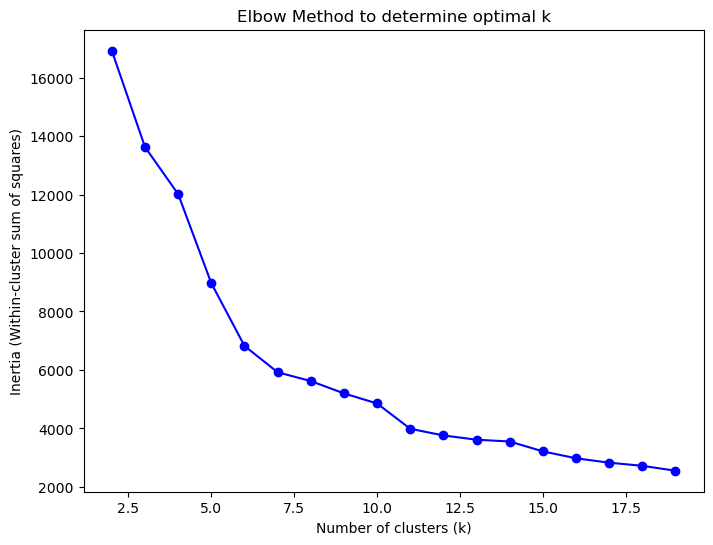

In [9]:
inertia = []
K_range = range(2, 20)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, 'bx-', marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method to determine optimal k')
plt.show()

**Alternative method - NOT USED!!!**

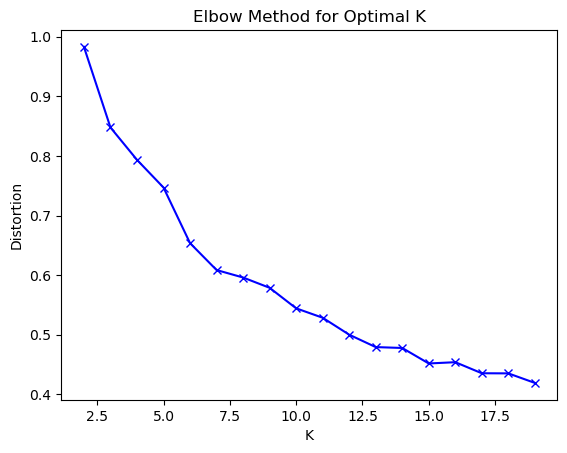

In [10]:
# Determine k by minimizing the distortion - 
# the sum of the squared distances between each observation vector and its centroid
distortions = []
# We try training models for all possible number of clusters in the range and calculate their distrtion
for k in K_range:
    # n_init moves the "center" 10 times. Can be set to auto
    model = KMeans(n_clusters=k, n_init=20)
    model.fit(X_scaled)
    # Take the sum of each distance between a pair (x, y) and the Kmeans center,
    # and divide it by number of rows to get the average distance.
    distortions.append(sum(np.min(cdist(X_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0]) 
# Plot the distortion to discover the elbow
plt.title('Elbow Method for Optimal K')
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

### Determine number of clusters by Silhoutte score
Now we try to determine the best number of clusters by the silhoutte method.

In [11]:
# Determine k by maximising the silhouette score for each number of clusters
scores = []
for k in K_range:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(X_scaled)
    score = metrics.silhouette_score(X_scaled, model.labels_, metric='euclidean', sample_size=len(X_scaled))
    print("\nNumber of clusters =", k)
    print("Silhouette score =", score)
    scores.append(score)


Number of clusters = 2
Silhouette score = 0.5800592996493321

Number of clusters = 3
Silhouette score = 0.33721533228090533

Number of clusters = 4
Silhouette score = 0.3596985838276145

Number of clusters = 5
Silhouette score = 0.3765628345841585

Number of clusters = 6
Silhouette score = 0.4296936401170287

Number of clusters = 7
Silhouette score = 0.34973668662330953

Number of clusters = 8
Silhouette score = 0.3471180977273212

Number of clusters = 9
Silhouette score = 0.3482920721205556

Number of clusters = 10
Silhouette score = 0.3527079087261484

Number of clusters = 11
Silhouette score = 0.34781397603964725

Number of clusters = 12
Silhouette score = 0.34861195265246386

Number of clusters = 13
Silhouette score = 0.33555802307244453

Number of clusters = 14
Silhouette score = 0.32839799905362566

Number of clusters = 15
Silhouette score = 0.32258084385594243

Number of clusters = 16
Silhouette score = 0.31711857817325106

Number of clusters = 17
Silhouette score = 0.323558593

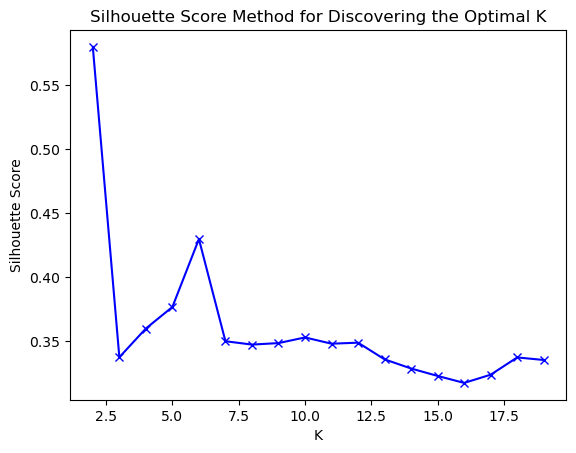

In [12]:
# Plot the silhouette scores to find the highest
plt.title('Silhouette Score Method for Discovering the Optimal K')
plt.plot(K_range, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

### Conclusion
Since the silhoutte score suggests three clusters as the optimal number and Elbow suggests 15 we could try with both number of clusters.

It could also be an idea to try with less columns, as this would make it easier to find similarities and make clusters, as not that many values are taken into accaount.

## Train a model
Now we will train a kmeans model with a chosen number of columns. Based on our analysis this should be 3 or 15.

In [29]:
# Optimal number of clusters K
num_clusters = 6

In [30]:
# Create an instance of KMeans classifier
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=20)
# init: method of experimemtal finding the initial location of the centroids
# n_init: the algorithm will run n_init times with different cetroids and the best result of those will be taken

In [31]:
# Train the KMeans clustering model
kmeans.fit(X_scaled)

KMeans(n_clusters=6, n_init=20)

## Implement model for prediction
Add new column to the original data frame, to see which rows goes in which column.

In [32]:
# Predict clusters in X
df['Cluster'] = kmeans.predict(X_scaled)
y = df['Cluster']
df['Cluster'].sample(20)

1618    1
5376    3
3124    1
3005    1
3054    1
1206    1
962     1
2502    1
1494    1
265     3
5561    2
924     1
5456    2
1635    0
3811    2
2440    1
1519    2
7338    0
5014    0
7484    1
Name: Cluster, dtype: int32

## Review results
First see clusters one by one

Cluster  0 :  (1404, 3)


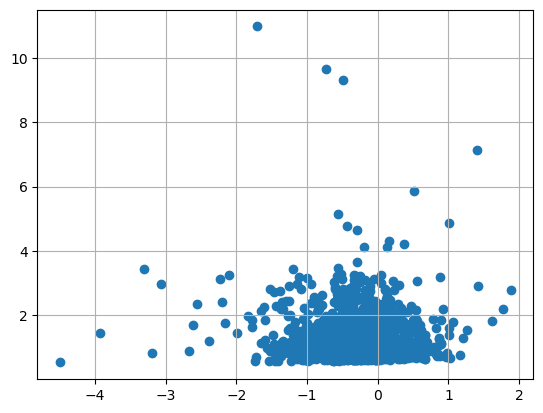

Cluster  1 :  (4328, 3)


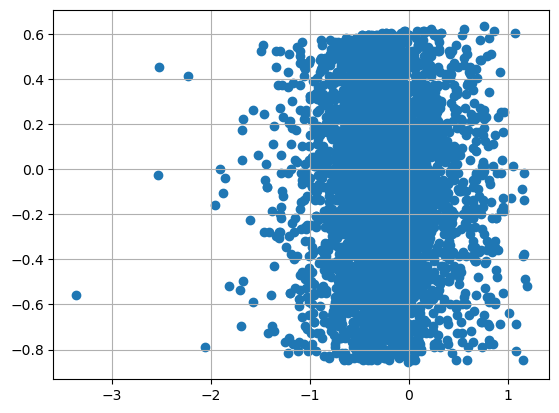

Cluster  2 :  (887, 3)


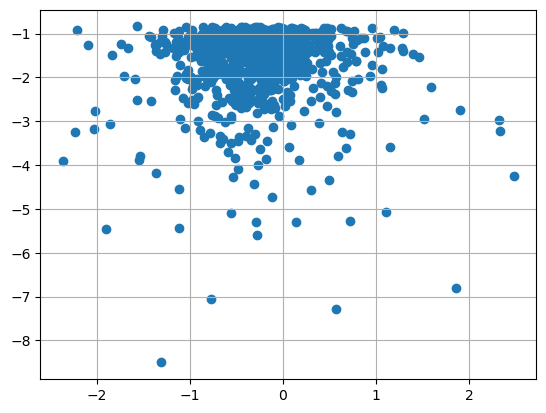

Cluster  3 :  (638, 3)


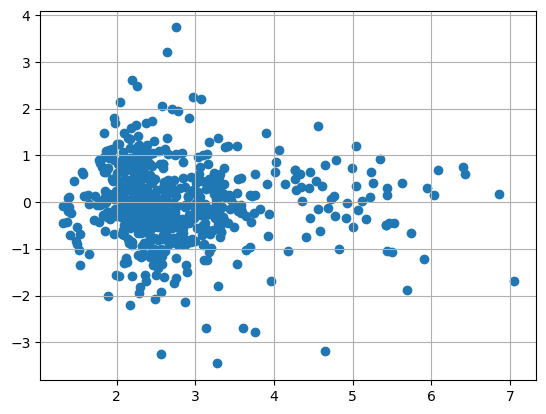

Cluster  4 :  (127, 3)


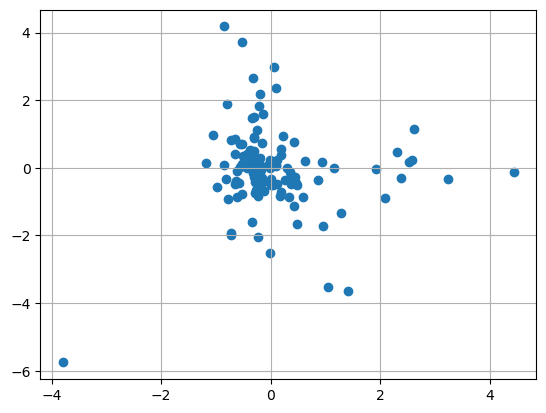

Cluster  5 :  (116, 3)


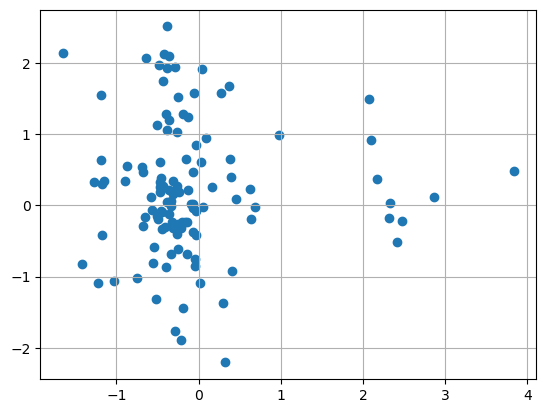

In [33]:
# Split the clusters, for demo purpose only
for i in range(num_clusters):
    # slice the cluster
    cluster = X_scaled[y == i]    
    # print the shape
    print("Cluster ", i, ": ", cluster.shape)    
    # plot the points of this cluster
    plt.scatter(cluster[:, 0], cluster[:, 1])   
    plt.grid(True)
    plt.show()

Then all clusters in one plot

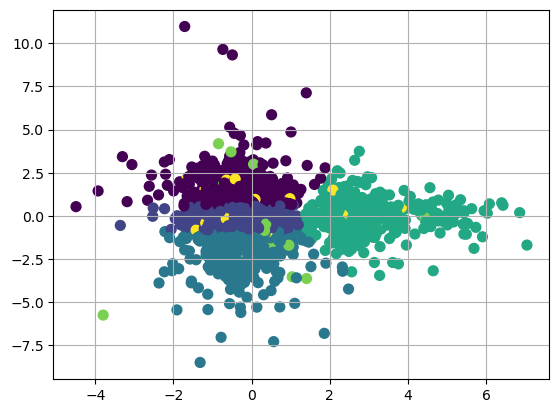

In [34]:
# Plot the points with color code of the predicted clusters
# viridis - a color map, https://matplotlib.org/users/colormaps.html
# s - marker size, here, the dots size
# c - marker color, here taken from the predicted clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=50, cmap='viridis')

plt.grid(True)
plt.show()

In [35]:
score = silhouette_score(X_scaled, df['Cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.43061731950021237


Very low silhouette score suggests that the clustering are not optimal, and maybe does not show anything.

### Analysis and intepretation of clustering
Here we have a closer look at the clusters too see if we can recognize patterns in the clusters.

In [36]:
# Shows the mean in all clusters for every column
cluster_summary = df.groupby('Cluster').mean(numeric_only=True)
# Only show column
cluster_summary.iloc[:, 19:]

# Use to only select specific columns
#cluster_summary[['OPEN_CLOSE_CHANGE_%_Gold', 'Inflation_Rate_Change']]

,Change % Gold,OPEN_CLOSE_CHANGE_%_SP500,OPEN_CLOSE_CHANGE_%_RUSSELL2000,OPEN_CLOSE_CHANGE_%_Gold,LOW_HIGH_CHANGE_%_SP500,LOW_HIGH_CHANGE_%_RUSSELL2000,LOW_HIGH_CHANGE_%_Gold,Interest_Rate_Change,Inflation_Rate_Change,Unemployment_Rate_Change,CPI_Change,VOLUME_CHANGE_%_RUSSELL2000,VOLUME_CHANGE_%_SP500,Market_Movement
Cluster,,,,,,,,,,,,,,
0,1.303533,0.000256,-0.000386,0.011974,0.026897,0.016258,0.011473,0.000071,0.000000,-0.000712,0.004196,0.044995,0.030980,0.537749
1,-0.065691,0.001423,0.000343,-0.001108,0.023882,0.011884,0.004348,-0.000356,0.000000,0.000023,0.004642,0.014289,0.022717,0.553835
2,-1.610609,0.000998,0.000036,-0.016115,0.027849,0.017038,0.014554,-0.000124,0.000000,0.000902,0.003585,0.049641,0.059918,0.503946
3,-0.014451,0.066758,0.002289,-0.005763,0.023622,0.009684,0.000729,-0.000611,0.000157,-0.000784,0.009091,0.029849,0.052783,0.614420
4,-0.019606,0.007506,0.002183,-0.000813,0.025672,0.013908,0.006864,-0.050709,-0.142520,0.005512,0.276850,0.006813,0.026226,0.622047
5,0.231379,0.004834,0.000626,0.001368,0.024654,0.013937,0.007530,0.014052,0.137069,-0.012069,0.495836,-0.017816,-0.001903,0.551724


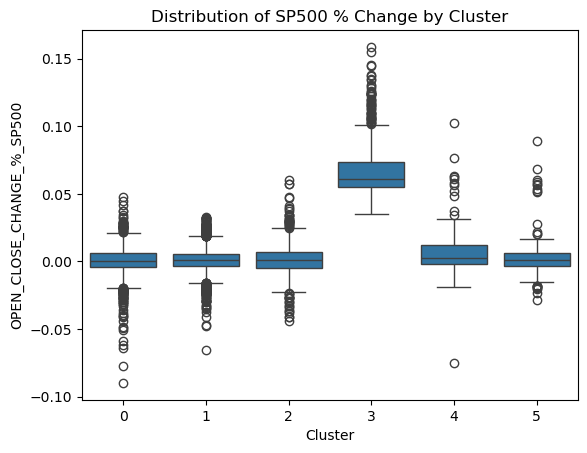

In [37]:
# Plot distribution of SP500 percentage changes across clusters
sns.boxplot(x='Cluster', y='OPEN_CLOSE_CHANGE_%_SP500', data=df)
plt.title('Distribution of SP500 % Change by Cluster')
plt.show()

## Supervised ML
We will use Supervised ML to try an predict if the market goes up or down. Therefore we will first have to create a new column with binary values, telling us if the market went up or down.

In [38]:
df['Market_Movement'] = df['OPEN_CLOSE_CHANGE_%_RUSSELL2000'].apply(lambda x: 1 if x > 0 else 0)
df['Market_Movement']

0       1
1       1
2       1
3       0
4       0
       ..
7495    1
7496    1
7497    0
7498    1
7499    0
Name: Market_Movement, Length: 7500, dtype: int64

In [39]:
# Drop Date column as it is not suitable for this
df_movement = df.drop(columns='Date')

In [40]:
# Split data into features (X) and what we want to predict (y)
X = df_movement.drop(columns=['Market_Movement'])
y = df_movement['Market_Movement']

In [41]:
# Split the data into traning and test and train out chosen model (GaussianNB)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GaussianNB()
model.fit(X_train, Y_train)

GaussianNB()

In [42]:
# Test the model score
print(model.score(X_test, Y_test))
print(model.score(X_train, Y_train))

0.5433333333333333
0.5541666666666667


Not that good results on either the testing or the training. We predict anyway, but should consider using less features.

In [43]:
prediction = model.predict(X_test)
prediction

array([1, 0, 1, ..., 1, 1, 1])

In [44]:
cmat = confusion_matrix(Y_test, prediction)
print(cmat)
print(classification_report(Y_test, prediction))

[[128 551]
 [134 687]]
              precision    recall  f1-score   support

           0       0.49      0.19      0.27       679
           1       0.55      0.84      0.67       821

    accuracy                           0.54      1500
   macro avg       0.52      0.51      0.47      1500
weighted avg       0.52      0.54      0.49      1500



Our model are best at predicting a market movement upwards, but with no signifigance. It would be like flipping a coin.